## Библиотеки

In [18]:
import cv2
import numpy as np
from IPython.display import display, Image
from scripts import image_filters
from ultralytics import YOLO
import matplotlib.pyplot as plt
import csv
import datetime
import time
import os
import psutil

In [2]:
img_path = 'images/IMG_3456.jpg'
image = cv2.imread(img_path)

## Предварительная обработка изображений

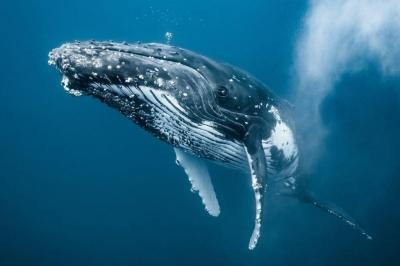

In [3]:
display(Image(data=cv2.imencode('.jpg', image)[1].tobytes()))

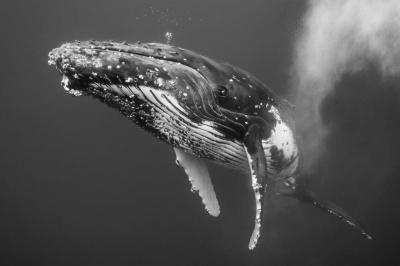

In [4]:
grey = image_filters.color_grader(image, mode='gray')
display(Image(data=cv2.imencode('.jpg', grey)[1].tobytes()))

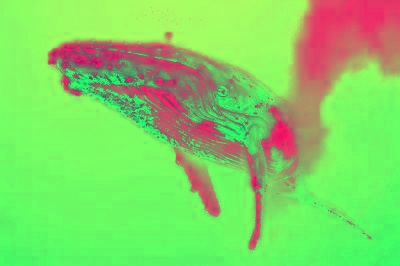

In [5]:
filtered = image_filters.color_grader(image, mode='hsv')
display(Image(data=cv2.imencode('.jpg', filtered)[1].tobytes()))

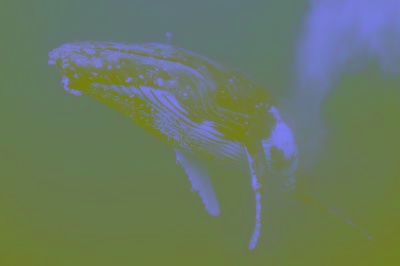

In [6]:
filtered = image_filters.color_grader(image, mode='lab')
display(Image(data=cv2.imencode('.jpg', filtered)[1].tobytes()))

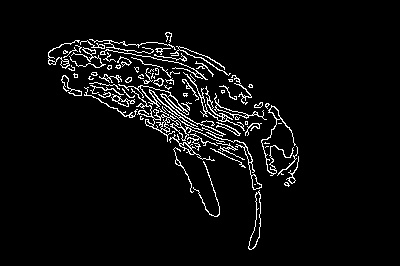

In [7]:
filtered = image_filters.edge_detector(image, min_thresh=10, max_thresh=180)
display(Image(data=cv2.imencode('.jpg', filtered)[1].tobytes()))

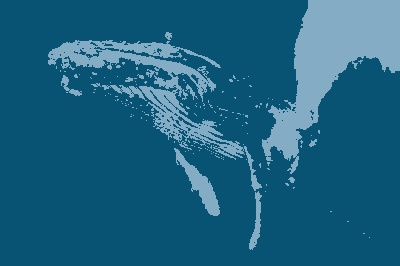

In [8]:
filtered = image_filters.kmeans_segmentation(image, K=2)
display(Image(data=cv2.imencode('.jpg', filtered)[1].tobytes()))

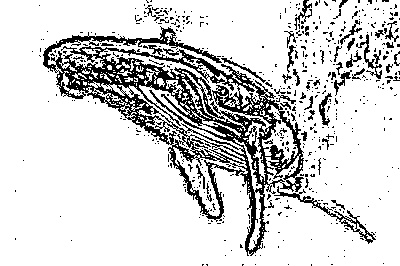

In [9]:
filtered = image_filters.adaptive_segmentation(image)
display(Image(data=cv2.imencode('.jpg', filtered)[1].tobytes()))

## Обучение модели

In [20]:
root_dir = ''

In [26]:
model = YOLO('yolo11n.pt')  # или 'yolov8n.yaml'

# Только параметры обучения (без Solutions)
train_params = {
    'data': 'data.yaml',  # путь к вашему data.yaml
    'epochs': 100,
    'batch': 16,
    'imgsz': 640,
    'lr0': 5e-4,  # начальный learning rate
    'optimizer': 'Adam',
    'weight_decay': 0.0001,
    'cos_lr': True,  # косинусный LR scheduler
    'warmup_epochs': 3,  # разогрев LR
    'warmup_momentum': 1e-6,  # начальный LR при разогреве
}

results = model.train(**train_params)

New https://pypi.org/project/ultralytics/8.3.145 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.141  Python-3.9.7 torch-2.1.1+cpu CPU (AMD Ryzen 5 5500U with Radeon Graphics)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0005, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train3, nbs=64, nms=False, opset=None, optimize=False, opt

train: Scanning C:\Users\Илюха\VS code\Диплом\predtren\train\labels... 9914 images, 0 backgrounds, 0 corrupt: 100%|██████████| 9914/9914 [00:33<00:00, 295.19it/s]


train: New cache created: C:\Users\\VS code\\predtren\train\labels.cache
albumentations: __init__() got an unexpected keyword argument 'quality_range'
val: Fast image access  (ping: 0.10.0 ms, read: 25.53.6 MB/s, size: 279.1 KB)


val: Scanning C:\Users\Илюха\VS code\Диплом\predtren\valid\labels... 1229 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1229/1229 [00:05<00:00, 231.51it/s]

val: New cache created: C:\Users\\VS code\\predtren\valid\labels.cache


Plotting labels to runs\detect\train3\labels.jpg... 
optimizer: Adam(lr=0.0005, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0001), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\train3
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100         0G      2.405      3.828      1.533         64        640:   7%|▋         | 44/620 [05:17<1:09:10,  7.21s/it]


KeyboardInterrupt: 

## Тестирование на одном кадре


0: 384x640 1  , 77.2ms
Speed: 2.6ms preprocess, 77.2ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


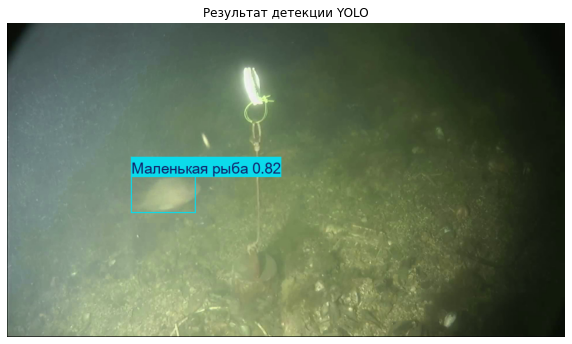

Результат сохранен как: predtren/test/detected.jpg


In [10]:
def detect_and_show(model_path, image_path, output_path='predtren/test/detected.jpg', show_original=False):
    """Обрабатывает изображение с помощью YOLO и показывает результат"""
    # Загрузка модели и изображения
    model = YOLO(model_path)
    image = cv2.imread(image_path)
    
    if image is None:
        print(f"Ошибка: не удалось загрузить изображение {image_path}")
        return
    
    # Конвертация BGR в RGB для корректного отображения
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Показ оригинального изображения (если нужно)
    if show_original:
        plt.figure(figsize=(10, 6))
        plt.title("Оригинальное изображение")
        plt.imshow(image_rgb)
        plt.axis('off')
        plt.show()
    
    # Детекция объектов
    results = model(image)
    
    # Визуализация и сохранение результатов
    for r in results:
        detected_image = r.plot()  # Получаем изображение с детекцией (в BGR)
        detected_image_rgb = cv2.cvtColor(detected_image, cv2.COLOR_BGR2RGB)
        
        # Сохраняем результат
        cv2.imwrite(output_path, detected_image)
        
        # Отображаем в Jupyter
        plt.figure(figsize=(10, 6))
        plt.title("Результат детекции YOLO")
        plt.imshow(detected_image_rgb)
        plt.axis('off')
        plt.show()
        
        print(f"Результат сохранен как: {output_path}")

# Пример использования
model_path = 'runs/detect/train2/weights/best.pt'  # Ваша модель YOLO
image_path = "predtren/test/test_image_1.png"  # Ваше изображение

detect_and_show(model_path, image_path)

## Тестирование на видео

In [2]:
def process_video_with_yolo(model_path, input_video_path, output_video_path, new_width=960, new_height=540):
    # Загрузка модели YOLO
    model = YOLO(model_path)
    
    # Открытие видеофайла
    cap = cv2.VideoCapture(input_video_path)
    if not cap.isOpened():
        raise ValueError(f"Не удалось открыть видеофайл: {input_video_path}")
    
    # Получение параметров оригинального видео
    orig_fps = cap.get(cv2.CAP_PROP_FPS)
    orig_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    orig_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    # Создание объекта для записи видео с новым разрешением
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(output_video_path, fourcc, orig_fps, (new_width, new_height))
    
    frame_count = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        # Изменение разрешения кадра
        frame_resized = cv2.resize(frame, (new_width, new_height))
        
        
        # Детекция объектов с помощью YOLO
        results = model(frame_resized)
        
        # Визуализация результатов
        for r in results:
            # Получение кадра с bounding boxes (в BGR формате)
            im_bgr = r.plot()
            
            # Запись кадра в выходное видео
            out.write(im_bgr)
        
        frame_count += 1
        if frame_count % 100 == 0:
            print(f"Обработано кадров: {frame_count}")
    
    # Освобождение ресурсов
    cap.release()
    out.release()
    print(f"Видео с детекцией сохранено как: {output_video_path}")

# Параметры
model_path = 'runs/detect/train2/weights/best.pt'
input_video_path = "predtren/test/2019-02-20_19-23-53to2019-02-20_19-24-12_1.avi"
output_video_path = 'predtren/test/test_video_with_yolo_detection.avi'
new_width, new_height = 960, 540  # Новое разрешение

# Обработка видео
process_video_with_yolo(model_path, input_video_path, output_video_path, new_width, new_height)


0: 384x640 (no detections), 158.7ms
Speed: 5.1ms preprocess, 158.7ms inference, 7.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 80.8ms
Speed: 2.1ms preprocess, 80.8ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 79.4ms
Speed: 2.4ms preprocess, 79.4ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 80.7ms
Speed: 2.0ms preprocess, 80.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 80.2ms
Speed: 3.2ms preprocess, 80.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 83.4ms
Speed: 2.1ms preprocess, 83.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 92.9ms
Speed: 10.4ms preprocess, 92.9ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 80.9ms
Speed: 2.5ms preprocess, 80.9m

## Тестирование в режиме реального потока

In [ ]:
def process_stream_with_full_stats(model_path, input_video_path, output_csv_path, camera_id, new_width=960, new_height=540):
    """
    Эмулирует обработку видеопотока с пропуском кадров и собирает полную статистику
    включая параметры видео, время, память и количество пропущенных кадров.
    """
    # --- Блок инициализации статистики ---
    start_total_time = time.monotonic()
    process = psutil.Process(os.getpid())
    total_frames_processed = 0
    total_frames_skipped = 0
    
    # 1. Загрузка модели YOLO
    try:
        model = YOLO(model_path)
    except Exception as e:
        print(f"Ошибка загрузки модели: {e}")
        return

    # 2. Открытие видеофайла
    cap = cv2.VideoCapture(input_video_path)
    if not cap.isOpened():
        raise ValueError(f"Не удалось открыть видеофайл: {input_video_path}")

    # 3. Получение параметров видео
    orig_fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames_in_video = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    # НОВОЕ: Получаем оригинальное разрешение
    orig_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    orig_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    if orig_fps == 0:
        orig_fps = 25
    
    print(f"Видеофайл: {os.path.basename(input_video_path)}")
    print(f"Исходные параметры: {orig_width}x{orig_height} @ {orig_fps:.2f} FPS, Всего кадров: {total_frames_in_video}")
    print(f"Параметры обработки: {new_width}x{new_height}")

    # 4. Подготовка CSV-файла
    try:
        with open(output_csv_path, 'w', newline='', encoding='utf-8') as csvfile:
            csv_writer = csv.writer(csvfile)
            csv_writer.writerow(['timestamp', 'camera_id', 'class_name', 'x1', 'y1', 'x2', 'y2', 'confidence'])
            
            print("\nНачало обработки потока...")
            
            # 5. Основной цикл обработки
            while cap.isOpened():
                current_frame_pos = cap.get(cv2.CAP_PROP_POS_FRAMES)
                
                ret, frame = cap.read()
                if not ret or current_frame_pos >= total_frames_in_video:
                    break

                start_time = time.time()
                
                frame_resized = cv2.resize(frame, (new_width, new_height))
                results = model(frame_resized, verbose=False)
                detection_time = datetime.datetime.now().isoformat()
                
                for r in results:
                    for box in r.boxes:
                        x1, y1, x2, y2 = map(int, box.xyxy[0])
                        confidence = round(float(box.conf[0]), 2)
                        class_id = int(box.cls[0])
                        class_name = model.names[class_id]
                        csv_writer.writerow([detection_time, camera_id, class_name, x1, y1, x2, y2, confidence])
                
                total_frames_processed += 1
                processing_time = time.time() - start_time
                frames_elapsed_during_processing = processing_time * orig_fps
                frames_to_skip = int(frames_elapsed_during_processing) - 1

                if frames_to_skip > 0:
                    next_frame_to_read = current_frame_pos + frames_to_skip
                    total_frames_skipped += frames_to_skip
                    
                    if next_frame_to_read < total_frames_in_video:
                        cap.set(cv2.CAP_PROP_POS_FRAMES, next_frame_to_read)
                    else:
                        break
                
                if total_frames_processed % 50 == 0:
                    print(f"  Обработано: {total_frames_processed} кадров, Пропущено: {total_frames_skipped} кадров...")

    except Exception as e:
        print(f"Произошла ошибка во время обработки: {e}")
    finally:
        # --- Блок сбора и вывода итоговой статистики ---
        end_total_time = time.monotonic()
        total_execution_time = end_total_time - start_total_time
        memory_info = process.memory_info()
        memory_used_mb = memory_info.rss / (1024 ** 2)
        
        cap.release()
        
        print("\n" + "="*45)
        print("              ИТОГОВАЯ СТАТИСТИКА")
        print("="*45)
        
        # НОВЫЙ БЛОК: Параметры видео
        print("Параметры видео:")
        print(f"  Исходное разрешение:   {orig_width}x{orig_height}")
        print(f"  Разрешение обработки:  {new_width}x{new_height}")
        print(f"  Исходный FPS:            {orig_fps:.2f}")
        print("-" * 45)

        print("Производительность:")
        print(f"  Общее время обработки:   {total_execution_time:.2f} секунд")
        print(f"  Пиковое использование RAM:  {memory_used_mb:.2f} МБ")
        print("-" * 45)

        print("Статистика по кадрам:")
        print(f"  Всего кадров в видео:      {total_frames_in_video}")
        print(f"  Обработано кадров:         {total_frames_processed}")
        print(f"  Пропущено кадров:          {total_frames_skipped}")
        if total_frames_processed > 0:
            avg_time_per_frame = (total_execution_time / total_frames_processed) * 1000
            print(f"  Среднее время на кадр:     {avg_time_per_frame:.2f} мс")
        
        print("="*45)
        print(f"\nОбработка завершена. Результаты сохранены в: {output_csv_path}")


# --- Параметры для запуска ---
model_path = 'runs/detect/train2/weights/best.pt'
input_video_path = "predtren/test/2019-02-20_19-23-53to2019-02-20_19-24-12_1.avi"
output_csv_path = 'predtren/test/detection_log.csv'
camera_id_emulator = "CAM-01" 
new_width, new_height = 960, 540

# Запуск функции
process_stream_with_full_stats(
    model_path=model_path,
    input_video_path=input_video_path,
    output_csv_path=output_csv_path,
    camera_id=camera_id_emulator,
    new_width=new_width,
    new_height=new_height
)

Видеофайл: 2019-02-20_19-23-53to2019-02-20_19-24-12_1.avi
Исходные параметры: 1920x1080 @ 15.00 FPS, Всего кадров: 298
Параметры обработки: 960x540

Начало обработки потока...
  Обработано: 50 кадров, Пропущено: 2 кадров...
  Обработано: 100 кадров, Пропущено: 2 кадров...
  Обработано: 150 кадров, Пропущено: 2 кадров...
  Обработано: 200 кадров, Пропущено: 3 кадров...
  Обработано: 250 кадров, Пропущено: 3 кадров...

              ИТОГОВАЯ СТАТИСТИКА
Параметры видео:
  Исходное разрешение:   1920x1080
  Разрешение обработки:  960x540
  Исходный FPS:            15.00
---------------------------------------------
Производительность:
  Общее время обработки:   27.00 секунд
  Пиковое использование RAM:  500.25 МБ
---------------------------------------------
Статистика по кадрам:
  Всего кадров в видео:      298
  Обработано кадров:         298
  Пропущено кадров:          3
  Среднее время на кадр:     90.60 мс

Обработка завершена. Результаты сохранены в: predtren/test/detection_log.csv
